# Learning the potential of a conservative vector field

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

# Problem statment

We want to produce an approximation (up to an additive constant) of a potential $S:\mathbb{R}^n\to\mathbb{R}$ via samples from its gradient field $s:=\nabla S :\mathbb{R}^n\to\mathbb{R}^n$.

We use the example
$$S:\mathbb{R}^2 \ni x \mapsto e^{-\frac{1}{2}\|x\|^2} \in \mathbb{R},$$
for which we have
$$s:\mathbb{R}^2 \ni x \mapsto -x e^{-\frac{1}{2}\|x\|^2} \in \mathbb{R}^2.$$

In [2]:
def S(x):
    return np.exp(-0.5 * np.linalg.norm(x, axis=0)**2)

def s(x):
    return -x * S(x)

## Visualization of the potential $S$

In [3]:
n = 100

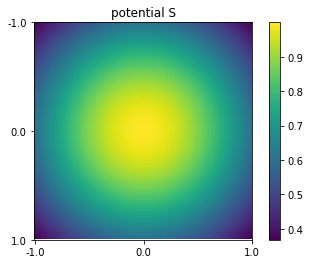

In [4]:
S_matrix = np.zeros([n]*2)
for i, y in enumerate(np.linspace(1, -1, n)):
    for j, x in enumerate(np.linspace(-1, 1, n)):
        S_matrix[i,j] = S(np.array([x, y]))

plt.imshow(S_matrix)
plt.title("potential S")
plt.colorbar()
ax = plt.gca();
ax.set_xticks([0, n//2, n]);
ax.set_yticks([0, n//2, n]);
ax.set_xticklabels(np.linspace(-1, 1, 3));
ax.set_yticklabels(np.linspace(-1, 1, 3));
plt.show()

## Visualization of the vector field $s$

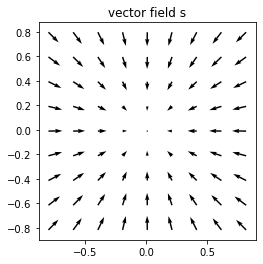

In [5]:
s_x_matrix = np.zeros([n]*2)
s_y_matrix = np.zeros([n]*2)

for i, y in enumerate(np.linspace(1, -1, n)):
    for j, x in enumerate(np.linspace(-1, 1, n)):
        grad_x, grad_y = s(np.array([x, y]))
        s_x_matrix[i,j] = grad_x
        s_y_matrix[i,j] = grad_y

skip = 10
fig, ax = plt.subplots()
ax.quiver(np.linspace(-1, 1, n)[skip::skip],
          np.linspace(1, -1, n)[skip::skip],
          s_x_matrix[skip::skip,skip::skip],
          s_y_matrix[skip::skip,skip::skip])
ax.set(aspect=1, title='vector field s')
plt.show()

# Define model for scalar field

In [6]:
class ScalarField(nn.Module):
    def __init__(self):
        super(ScalarField, self).__init__()
        self.linear0 = nn.Linear(2, 10)
        self.linear1 = nn.Linear(10, 10)
        self.linear2 = nn.Linear(10, 1)

    def forward(self, x):
        out = x
        out = torch.sigmoid(self.linear0(out))
        out = torch.sigmoid(self.linear1(out))
        out = self.linear2(out)
        return out

# Train the Scalar field directly (as a test)

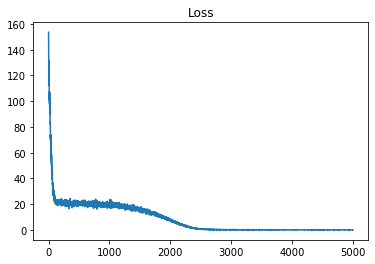

In [7]:
scalarField = ScalarField()
batch_size = 256
optimizer = torch.optim.Adam(scalarField.parameters())
losses = []

for _ in range(5000):
    xs = np.random.randn(2, batch_size).astype(np.float32)
    ys = S(xs)
    xs = torch.from_numpy(xs.T)
    ys = torch.from_numpy(ys.T)

    optimizer.zero_grad()
    ys_predict = scalarField(xs)
    loss = torch.sum((ys-ys_predict.flatten())**2)
    losses += [loss.item()]
    loss.backward()
    optimizer.step()

plt.title("Loss")
plt.plot(losses)
plt.show()

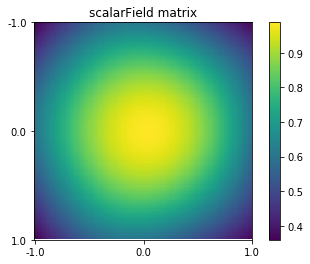

In [8]:
def apply_scalarField_np(x):
    scalarField.eval()
    out = scalarField(torch.from_numpy(x.astype(np.float32)).view(1,-1))
    scalarField.train()
    return out.item()

scalarField_matrix = np.zeros([n]*2)
for i, y in enumerate(np.linspace(1, -1, n)):
    for j, x in enumerate(np.linspace(-1, 1, n)):
        scalarField_matrix[i,j] = apply_scalarField_np(np.array([x, y]))

plt.imshow(scalarField_matrix)
plt.title("scalarField matrix")
plt.colorbar()
ax = plt.gca();
ax.set_xticks([0, n//2, n]);
ax.set_yticks([0, n//2, n]);
ax.set_xticklabels(np.linspace(-1, 1, 3));
ax.set_yticklabels(np.linspace(-1, 1, 3));
plt.show()

# Train the Scalar field indirectly

## Define class for conservative vector field

In [9]:
class ConservativeVectorField(nn.Module):
    def __init__(self, scalarField):
        super(ConservativeVectorField, self).__init__()
        self.scalarField = scalarField
    
    def forward(self, xs):
        xs_grad = xs.requires_grad_(True)
        scalars = self.scalarField(xs_grad)

        gradients = torch.autograd.grad(outputs=scalars,
                                        inputs=xs_grad,
                                        grad_outputs=torch.ones_like(scalars),
                                        create_graph=True,
                                        retain_graph=True)[0]

        return gradients

## Train the Scalar field indirectly

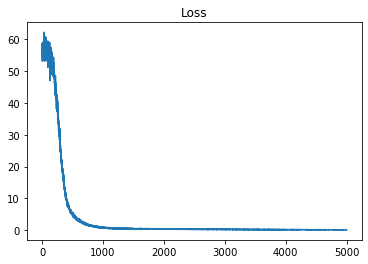

In [10]:
scalarField = ScalarField()
conservativeVectorField = ConservativeVectorField(scalarField)

batch_size = 256
optimizer = torch.optim.Adam(scalarField.parameters())
losses = []

for _ in range(5000):
    xs = np.random.randn(2, batch_size).astype(np.float32)
    ys = s(xs)
    xs = torch.from_numpy(xs.T)
    ys = torch.from_numpy(ys.T)

    optimizer.zero_grad()
    ys_predict = conservativeVectorField(xs)
    loss = torch.sum((ys-ys_predict)**2)
    losses += [loss.item()]
    loss.backward()
    optimizer.step()

plt.title("Loss")
plt.plot(losses)
plt.show()

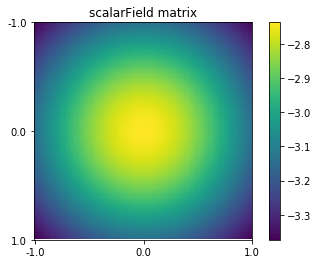

In [11]:
def apply_scalarField_np(x):
    scalarField.eval()
    out = scalarField(torch.from_numpy(x.astype(np.float32)).view(1,-1))
    scalarField.train()
    return out.item()

scalarField_matrix = np.zeros([n]*2)
for i, y in enumerate(np.linspace(1, -1, n)):
    for j, x in enumerate(np.linspace(-1, 1, n)):
        scalarField_matrix[i,j] = apply_scalarField_np(np.array([x, y]))

plt.imshow(scalarField_matrix)
plt.title("scalarField matrix")
plt.colorbar()
ax = plt.gca();
ax.set_xticks([0, n//2, n]);
ax.set_yticks([0, n//2, n]);
ax.set_xticklabels(np.linspace(-1, 1, 3));
ax.set_yticklabels(np.linspace(-1, 1, 3));
plt.show()

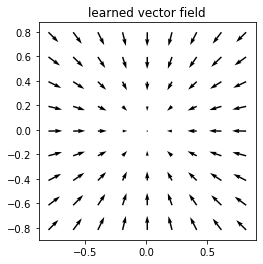

In [12]:
def apply_conservativeVectorField_np(x):
    conservativeVectorField.eval()
    out = conservativeVectorField(torch.from_numpy(x.astype(np.float32)).view(1,-1))
    conservativeVectorField.train()
    return out.detach().numpy()

conservativeVectorField_x_matrix = np.zeros([n]*2)
conservativeVectorField_y_matrix = np.zeros([n]*2)

for i, y in enumerate(np.linspace(1, -1, n)):
    for j, x in enumerate(np.linspace(-1, 1, n)):
        grad_x, grad_y = apply_conservativeVectorField_np(np.array([x, y])).T
        conservativeVectorField_x_matrix[i,j] = grad_x
        conservativeVectorField_y_matrix[i,j] = grad_y

skip = 10
fig, ax = plt.subplots()
ax.quiver(np.linspace(-1, 1, n)[skip::skip],
          np.linspace(1, -1, n)[skip::skip],
          conservativeVectorField_x_matrix[skip::skip,skip::skip],
          conservativeVectorField_y_matrix[skip::skip,skip::skip])
ax.set(aspect=1, title='learned vector field')
plt.show()